In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Graph creator using Configuration model

In [ ]:
!git clone https://github.com/mmiller96/netgan_pytorch.git

Cloning into 'netgan_pytorch'...
remote: Enumerating objects: 115, done.
remote: Counting objects: 100% (40/40), done.
remote: Compressing objects: 100% (34/34), done.
remote: Total 115 (delta 9), reused 29 (delta 6), pack-reused 75 (from 1)
Receiving objects: 100% (115/115), 74.92 MiB | 14.54 MiB/s, done.
Resolving deltas: 100% (36/36), done.


In [ ]:
import os
import sys
sys.path.append(os.path.abspath("/content/netgan_pytorch/netgan"))
sys.path.append(os.path.abspath("/content/drive/MyDrive/Colab Notebooks/project/finnal"))

In [3]:
import math
import networkx as nx
import numpy as np
import scipy
from santafe import plplot, plfit, degree_sequence, Average
import matplotlib.pyplot as plt


def create_graph(sigma, _lambda=5, _N=1000):
  for _ in range(100):
    #rv = weibull_min(-1*math.log(sigma), scale=_lambda)
    #seq = np.array(rv.rvs(size=1000))
    seq = np.random.weibull(-1*math.log(sigma), _N) * _lambda
    seq = np.round(seq).astype(int)
    seq = [_N-2 if val >= _N else val for val in seq]
    seq = [1 if val == 0 else val for val in seq]
    seq = [d + 1 if d % 2 != 0 else d for d in seq]
    g = nx.configuration_model(seq)
    g = nx.Graph(g)
    g.remove_edges_from(nx.selfloop_edges(g))
    if nx.is_connected(g):
      graph = nx.to_numpy_array(g)
      graph[graph!=0] = 1.0
      graph_nx = nx.from_numpy_array(graph)
      # graph_sparse = scipy.sparse.csr_matrix(graph)
      # n_edges = graph.sum()
      return graph_nx, seq
  raise ValueError("Could not generate a connected graph after 200 attempts.")


def graph_customization(graph):
  graph = nx.to_numpy_array(graph)
  graph[graph != 0] = 1.0
  graph_nx = nx.from_numpy_array(graph)
  graph_sparse = scipy.sparse.csr_matrix(graph)
  n_edges = graph.sum() / 2
  return graph, graph_nx, graph_sparse, n_edges


def topological_features(graph):
  return {
    'N': np.round(graph.number_of_nodes(), 2),
    'M': np.round(graph.number_of_edges(), 2),
    '<K>': np.round(graph.number_of_edges()*2/graph.number_of_nodes(), 2),
    '<L>': np.round(nx.average_shortest_path_length(graph), 2),
    'C': np.round(nx.average_clustering(graph), 2),
  }


from matplotlib.backends.backend_pdf import PdfPages
import json
import pandas as pd

def plot_topological_features(indices_performance):
  df = pd.DataFrame(indices_performance).T
  for _, value in indices_performance.items():
    keys = value.keys()
    break
  df.columns = list(keys)

  fig, ax = plt.subplots(figsize=(10, 6))
  ax.xaxis.set_visible(False)
  ax.yaxis.set_visible(False)
  ax.set_frame_on(False)

  table = ax.table(cellText=df.round(4).values, colLabels=df.columns, rowLabels=df.index, cellLoc='center', loc='center')
  with PdfPages('topological_features.pdf') as pdf:
    pdf.savefig(fig, bbox_inches='tight')

  plt.savefig(f'topological_features.jpg')
  plt.show()

  # with open("node_perculation.txt", "w") as f:
  #   f.write(json.dumps(indices_performance, indent=4))

def compute_heterogeneity(graph):
    deglist = degree_sequence(graph)
    max_degree = max(deglist)
    average = Average(degree_sequence(graph))
    xxx = deglist
    [alpha, xmin, L] = plfit(xxx)
    return [1/alpha, xmin/max_degree, L]

Creating a graph with most heterogeneity using CM

In [ ]:
from tqdm import tqdm


cm_alpha_val = []
cm_graph = []

indices_performance = {}

output_model = []
for i in tqdm(range(40)):
    g, seq = create_graph(0.50, _N=1000)
    _, graph_nx, _, n_edges = graph_customization(g)
    cm_graph.append(graph_nx)
    indices_performance[f'CM Output {i+1}'] = topological_features(graph_nx)

100%|██████████| 40/40 [00:49<00:00,  1.23s/it]


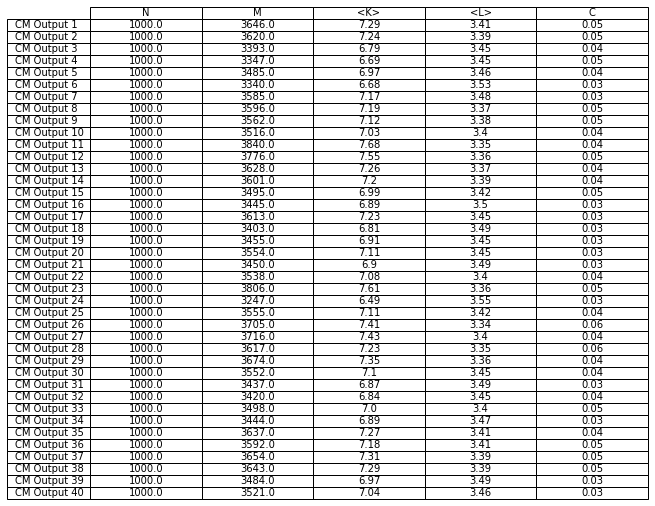

In [ ]:
import matplotlib.pyplot as plt


plot_topological_features(indices_performance)

In [ ]:
from santafe import main

mean_alpha=0
mean_xmin=0
mean_L=0
mean_max_digit=0
EPOCH = len(cm_graph)

for graph in cm_graph:
      # g, seq = create_graph(sigma)
      g = graph
      deglist = degree_sequence(g)
      xxx = deglist
      [alpha, xmin, L] = plfit(xxx)
      max_digit = max(deglist)

      mean_alpha=mean_alpha+alpha
      mean_xmin=mean_xmin+xmin
      mean_L=mean_L+L
      mean_max_digit=mean_max_digit+max_digit

mean_alpha=mean_alpha/EPOCH
mean_xmin=mean_xmin/EPOCH
mean_L=mean_L/EPOCH
mean_max_digit=mean_max_digit/EPOCH

print(mean_alpha)
print(mean_xmin)
print(mean_L)

alpha = [1/((alpha - min(all_alpha))/(max(all_alpha) - min(all_alpha))+1) for alpha in all_alpha]
xmin = [(xmin - min(all_xmin))/(max(all_xmin) - min(all_xmin)) for xmin in all_xmin]
data = [(_alpha + _xmin)/2 for _alpha, _xmin in zip(alpha, xmin)]

_alpha = 1/ ((mean_alpha - min(all_alpha)) / (max(all_alpha) - min(all_alpha))+1)
_xmin = (mean_xmin - min(all_xmin)) / (max(all_xmin) - min(all_xmin))
print((_alpha + _xmin)/2)

3.2572500000000004
17.475
-403.1038065804174
0.3886558309105509


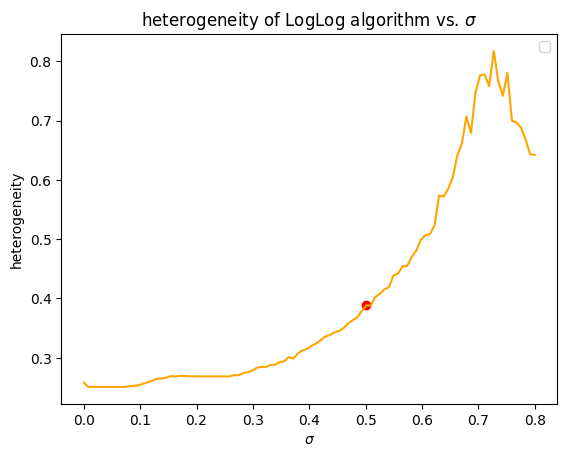

In [ ]:
x = np.linspace(start, end, steps)
plt.plot(x, data, color='orange')
plt.scatter([0.5], [(_alpha + _xmin)/2], color='red')
plt.title("heterogeneity of LogLog algorithm vs. $\sigma$")
plt.xlabel("$\sigma$")
plt.ylabel("heterogeneity")
plt.legend()
plt.show()

max: 3.5
min: 2.65
mod: 3.35
3.2589743589743594


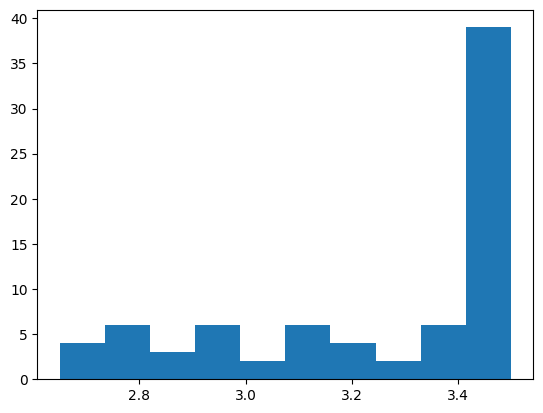

In [ ]:
import matplotlib.pyplot as plt
from scipy import stats

plt.hist(cm_alpha_val)
print(f'max: {max(cm_alpha_val)}')
print(f'min: {min(cm_alpha_val)}')
print(f'mod: {np.median(sorted(cm_alpha_val)[:-1])}')
print(np.mean(cm_alpha_val))

Getting the maximum

Now Let's try netgan

In [ ]:
from training import Trainer
import matplotlib.pyplot as plt
import networkx as nx
import torch
import pandas as pd
import numpy as np
import scipy
from utils import graph_from_scores
%matplotlib inline

In [ ]:
cm_alpha_val

[3.33,
 2.81,
 2.84,
 3.14,
 3.5,
 3.5,
 3.33,
 3.5,
 2.94,
 3.5,
 2.98,
 3.5,
 2.68,
 2.93,
 3.27,
 3.5,
 3.5,
 3.5,
 3.5,
 3.5,
 3.5,
 2.65,
 3.5,
 3.5,
 3.5,
 2.76,
 3.5,
 3.5,
 3.5,
 3.16,
 3.08,
 3.35,
 3.5,
 3.06,
 3.18,
 2.77,
 3.5,
 3.15,
 2.88,
 3.5,
 3.33,
 2.81,
 2.84,
 3.14,
 3.5,
 3.5,
 3.33,
 3.5,
 2.94,
 3.5,
 2.98,
 3.5,
 2.68,
 2.93,
 3.27,
 3.5,
 3.5,
 3.5,
 3.5,
 3.5,
 3.5,
 2.65,
 3.5,
 3.5,
 3.5,
 2.76,
 3.5,
 3.5,
 3.5,
 3.16,
 3.08,
 3.35,
 3.5,
 3.06,
 3.18,
 2.77,
 3.5,
 3.15]

In [ ]:
median_index = 0
alpha_val = cm_alpha_val[median_index]
graph = cm_graph[median_index]

print(alpha_val)

3.33


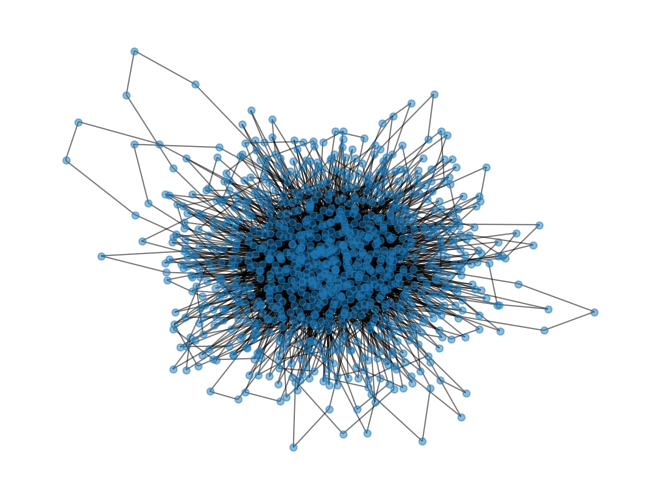

In [ ]:
nx.draw(graph, node_size=25, alpha=0.5)

In [ ]:
graph = nx.to_numpy_array(graph)
graph_nx = nx.from_numpy_array(graph)
graph[graph!=0] = 1.0
graph_sparse = scipy.sparse.csr_matrix(graph)
n_edges = graph_sparse.sum()

In [ ]:
trainer = Trainer(graph_sparse, len(graph), max_iterations=4000, rw_len=12, batch_size=128, H_gen=40, H_disc=30, H_inp=128, z_dim=16, lr=0.0003,
                  n_critic=3, gp_weight=10.0, betas=(.5, .9), l2_penalty_disc=5e-5, l2_penalty_gen=1e-7, temp_start=5.0,
                  val_share=0.2, test_share=0.1, seed=20, set_ops=False)

**** Using VAL criterion for early stopping with max patience of: 5****
iteration: 1      critic: 0.016229      gen -0.001128
iteration: 11      critic: -0.019358      gen 0.009813
iteration: 21      critic: -0.063204      gen 0.024115
iteration: 31      critic: -0.082000      gen 0.027618
iteration: 41      critic: -0.095724      gen 0.026677
iteration: 51      critic: -0.093058      gen 0.031529
iteration: 61      critic: -0.089235      gen 0.028990
iteration: 71      critic: -0.091772      gen 0.026056
iteration: 81      critic: -0.080976      gen 0.020646
iteration: 91      critic: -0.078152      gen 0.021164
Number iterations: 500
1
11
21
31
41
51
61
71
81
91
101
111
121
131
141
151
161
171
181
191
201
211
221
231
241
251
261
271
281
291
301
311
321
331
341
351
361
371
381
391
401
411
421
431
441
451
461
471
481
491
roc: 0.8064   avp: 0.8025   eo: 0.0156
Took 3.883193818728129 minutes so far..
iteration: 101      critic: -0.057844      gen 0.010386
iteration: 111      critic: -0.0

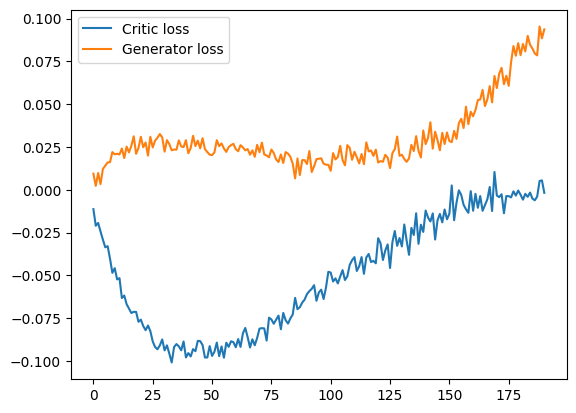

iteration: 201      critic: 0.005429      gen 0.096006
iteration: 211      critic: -0.000407      gen 0.102318
iteration: 221      critic: 0.011240      gen 0.096901
iteration: 231      critic: 0.010493      gen 0.099108
iteration: 241      critic: 0.011498      gen 0.105859
iteration: 251      critic: 0.004778      gen 0.120769
iteration: 261      critic: 0.011651      gen 0.123778
iteration: 271      critic: 0.000128      gen 0.140474
iteration: 281      critic: 0.005423      gen 0.152652
iteration: 291      critic: 0.002798      gen 0.157761
Number iterations: 500
1
11
21
31
41
51
61
71
81
91
101
111
121
131
141
151
161
171
181
191
201
211
221
231
241
251
261
271
281
291
301
311
321
331
341
351
361
371
381
391
401
411
421
431
441
451
461
471
481
491
roc: 0.8164   avp: 0.8291   eo: 0.0324
Took 11.635032709439596 minutes so far..
iteration: 301      critic: 0.001871      gen 0.167810
iteration: 311      critic: 0.008762      gen 0.172922
iteration: 321      critic: 0.000035      gen 0

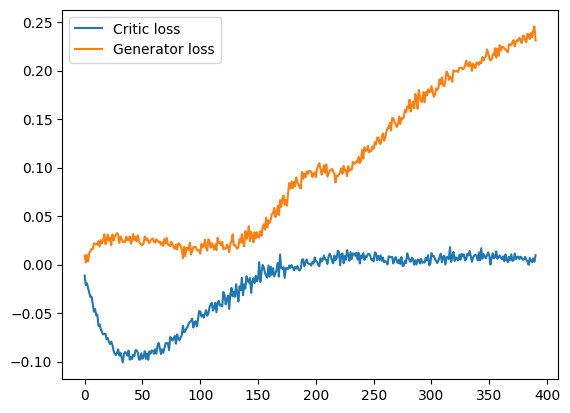

iteration: 401      critic: 0.006267      gen 0.237478
iteration: 411      critic: 0.003948      gen 0.254565
iteration: 421      critic: 0.007168      gen 0.248736
iteration: 431      critic: 0.006868      gen 0.260105
iteration: 441      critic: 0.008215      gen 0.277019
iteration: 451      critic: 0.003839      gen 0.281580
iteration: 461      critic: 0.004805      gen 0.286349
iteration: 471      critic: 0.005698      gen 0.289024
iteration: 481      critic: -0.001165      gen 0.302234
iteration: 491      critic: 0.002068      gen 0.313726
Number iterations: 500
1
11
21
31
41
51
61
71
81
91
101
111
121
131
141
151
161
171
181
191
201
211
221
231
241
251
261
271
281
291
301
311
321
331
341
351
361
371
381
391
401
411
421
431
441
451
461
471
481
491
roc: 0.8168   avp: 0.8311   eo: 0.0285
Took 19.340949308872222 minutes so far..
iteration: 501      critic: 0.001512      gen 0.327007
iteration: 511      critic: -0.001475      gen 0.335533
iteration: 521      critic: -0.005334      gen

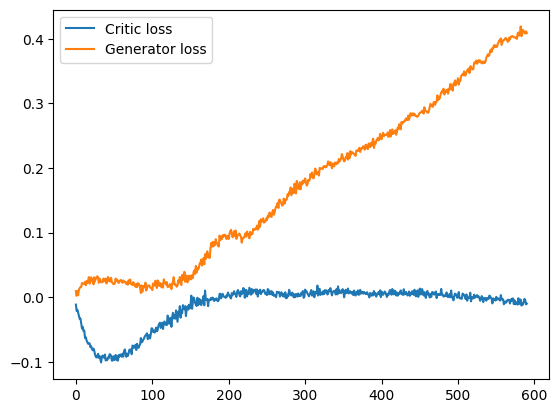

iteration: 601      critic: -0.011263      gen 0.415346
iteration: 611      critic: -0.007672      gen 0.412433
iteration: 621      critic: -0.012436      gen 0.413410
iteration: 631      critic: -0.016718      gen 0.423238
iteration: 641      critic: -0.015336      gen 0.420332
iteration: 651      critic: -0.013587      gen 0.409339
iteration: 661      critic: -0.012339      gen 0.411780
iteration: 671      critic: -0.017251      gen 0.402991
iteration: 681      critic: -0.008790      gen 0.398654
iteration: 691      critic: -0.021642      gen 0.387810
Number iterations: 500
1
11
21
31
41
51
61
71
81
91
101
111
121
131
141
151
161
171
181
191
201
211
221
231
241
251
261
271
281
291
301
311
321
331
341
351
361
371
381
391
401
411
421
431
441
451
461
471
481
491
roc: 0.8196   avp: 0.8309   eo: 0.0321
Took 27.17935057878494 minutes so far..
iteration: 701      critic: -0.018883      gen 0.399736
iteration: 711      critic: -0.031094      gen 0.389983
iteration: 721      critic: -0.020652

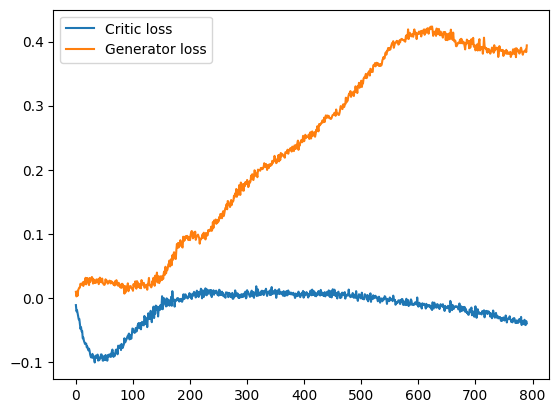

iteration: 801      critic: -0.038554      gen 0.384070
iteration: 811      critic: -0.036607      gen 0.395588
iteration: 821      critic: -0.049369      gen 0.396777
iteration: 831      critic: -0.042788      gen 0.395668
iteration: 841      critic: -0.048063      gen 0.395503
iteration: 851      critic: -0.051231      gen 0.392483
iteration: 861      critic: -0.052667      gen 0.394862
iteration: 871      critic: -0.054451      gen 0.392320
iteration: 881      critic: -0.050102      gen 0.394223
iteration: 891      critic: -0.060177      gen 0.404759
Number iterations: 500
1
11
21
31
41
51
61
71
81
91
101
111
121
131
141
151
161
171
181
191
201
211
221
231
241
251
261
271
281
291
301
311
321
331
341
351
361
371
381
391
401
411
421
431
441
451
461
471
481
491
roc: 0.8152   avp: 0.8305   eo: 0.0285
finished after 899 iterations
Took 34.94992472330729 minutes so far..


In [ ]:
trainer.train(create_graph_every=100, plot_graph_every=200, num_samples_graph=500000, stopping_criterion='val')

In [ ]:
import utils
import random

def connect_disconnected_graph(graph):
  while not nx.is_connected(graph):
    components = list(nx.connected_components(graph))
    comp1, comp2 = random.sample(components, 2)
    node1 = random.choice(list(comp1))
    node2 = random.choice(list(comp2))
    graph.add_edge(node1, node2)
    # print(f"Connected {node1} to {node2}")
  return graph

indices_performance = {}

indices_performance['main_graph'] = topological_features(graph_nx)

graph_synthetic = []
output_model = []
for i in range(40):
    trans_mat = trainer.create_transition_matrix(200000)
    graph_sampled = utils.graph_from_scores(trans_mat, n_edges)
    graph_synthetic.append(graph_sampled)
    graph_nx_sampled = nx.from_numpy_array(graph_sampled)
    # print(graph_nx_sampled)
    graph_nx_sampled = connect_disconnected_graph(graph_nx_sampled)
    output_model.append(graph_nx_sampled)
    indices_performance[f'Output model {i+1}'] = topological_features(graph_nx_sampled)

df = pd.DataFrame(indices_performance).T
df

1
11
21
31
41
51
61
71
81
91
101
111
121
131
141
151
161
171
181
191
1
11
21
31
41
51
61
71
81
91
101
111
121
131
141
151
161
171
181
191
1
11
21
31
41
51
61
71
81
91
101
111
121
131
141
151
161
171
181
191
1
11
21
31
41
51
61
71
81
91
101
111
121
131
141
151
161
171
181
191
1
11
21
31
41
51
61
71
81
91
101
111
121
131
141
151
161
171
181
191
1
11
21
31
41
51
61
71
81
91
101
111
121
131
141
151
161
171
181
191
1
11
21
31
41
51
61
71
81
91
101
111
121
131
141
151
161
171
181
191
1
11
21
31
41
51
61
71
81
91
101
111
121
131
141
151
161
171
181
191
1
11
21
31
41
51
61
71
81
91
101
111
121
131
141
151
161
171
181
191
1
11
21
31
41
51
61
71
81
91
101
111
121
131
141
151
161
171
181
191
1
11
21
31
41
51
61
71
81
91
101
111
121
131
141
151
161
171
181
191
1
11
21
31
41
51
61
71
81
91
101
111
121
131
141
151
161
171
181
191
1
11
21
31
41
51
61
71
81
91
101
111
121
131
141
151
161
171
181
191
1
11
21
31
41
51
61
71
81
91
101
111
121
131
141
151
161
171
181
191
1
11
21
31
41
51
61
71
81
91
101
1

,N,M,<K>,<L>,C
main_graph,1000.0,3646.0,7.29,3.41,0.05
Output model 1,1000.0,3646.0,7.29,3.47,0.03
Output model 2,1000.0,3646.0,7.29,3.46,0.03
Output model 3,1000.0,3646.0,7.29,3.48,0.02
Output model 4,1000.0,3646.0,7.29,3.47,0.02
Output model 5,1000.0,3646.0,7.29,3.47,0.02
Output model 6,1000.0,3646.0,7.29,3.49,0.03
Output model 7,1000.0,3646.0,7.29,3.48,0.03
Output model 8,1000.0,3646.0,7.29,3.47,0.02
Output model 9,1000.0,3646.0,7.29,3.48,0.02


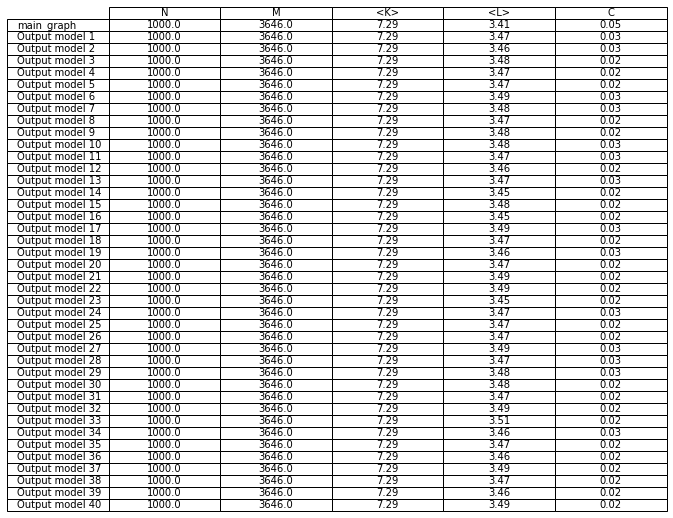

In [ ]:
plot_topological_features(indices_performance)

In [ ]:
mean_alpha=0
mean_xmin=0
mean_L=0
mean_max_digit=0
EPOCH = len(output_model)

for graph in output_model:
      # g, seq = create_graph(sigma)
      g = graph
      deglist = degree_sequence(g)
      xxx = deglist
      [alpha, xmin, L] = plfit(xxx)
      max_digit = max(deglist)

      mean_alpha+=alpha
      mean_xmin=mean_xmin+xmin
      mean_L=mean_L+L
      mean_max_digit=mean_max_digit+max_digit

mean_alpha=mean_alpha/EPOCH
mean_xmin=mean_xmin/EPOCH
mean_L=mean_L/EPOCH
mean_max_digit=mean_max_digit/EPOCH

print(mean_alpha)
print(mean_xmin)
print(mean_L)

alpha = [1/((alpha - min(all_alpha))/(max(all_alpha) - min(all_alpha))+1) for alpha in all_alpha]
xmin = [(xmin - min(all_xmin))/(max(all_xmin) - min(all_xmin)) for xmin in all_xmin]
data = [(_alpha + _xmin)/2 for _alpha, _xmin in zip(alpha, xmin)]

_alpha = 1/ ((mean_alpha - min(all_alpha)) / (max(all_alpha) - min(all_alpha))+1)
_xmin = (mean_xmin - min(all_xmin)) / (max(all_xmin) - min(all_xmin))
print((_alpha + _xmin)/2)

2.722750000000001
8.025
-1027.3684262713537
0.3571475720621979


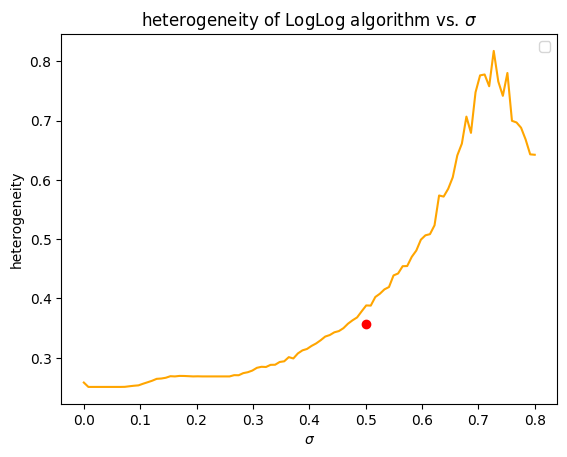

In [ ]:
x = np.linspace(start, end, steps)
plt.plot(x, data, color='orange')
plt.scatter([0.5], [(_alpha + _xmin)/2], color='red')
plt.title("heterogeneity of LogLog algorithm vs. $\sigma$")
plt.xlabel("$\sigma$")
plt.ylabel("heterogeneity")
plt.legend()
plt.show()

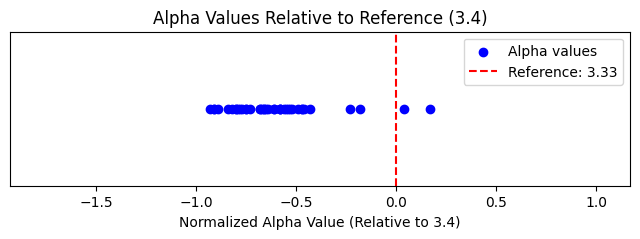

In [ ]:
alpha_values = []
for graph in output_model:
  # g, seq = create_graph(sigma)
  g = graph
  deglist = degree_sequence(g)
  xxx = deglist
  [alpha, xmin, L] = plfit(xxx)
  alpha_values.append(alpha)

reference_alpha = alpha_val
normalized_alphas = [alpha - reference_alpha for alpha in alpha_values]

plt.figure(figsize=(8, 2))
plt.scatter(normalized_alphas, [1]*len(normalized_alphas), color='b', marker='o', label='Alpha values')

plt.axvline(x=0, color='r', linestyle='--', label=f'Reference: {reference_alpha}')

plt.xlim(min(normalized_alphas) - 1, max(normalized_alphas) + 1)

plt.yticks([])
plt.xlabel('Normalized Alpha Value (Relative to 3.4)')
plt.title('Alpha Values Relative to Reference (3.4)')
plt.legend()

plt.show()

In [ ]:
for graph in output_model:
  nx.draw(graph, node_size=25, alpha=0.5)
  plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
for i, graph_sampled in enumerate(output_model):
    graph_sampled = scipy.sparse.csc_matrix(graph_sampled)
    path = 'graph_'+str(i) + '.npz'
    scipy.sparse.save_npz(path, graph_sampled)

In [ ]:
torch.save(trainer, 'cora.pt')